In [1]:
from keras.datasets import cifar10
import keras
import numpy as np
import tensorflow as tf

Using TensorFlow backend.


In [2]:
(x_train,y_train),(x_test,y_test) = cifar10.load_data()

In [3]:
x_train.shape

(50000, 32, 32, 3)

In [4]:
y_train.shape

(50000, 1)

In [5]:
x_test.shape

(10000, 32, 32, 3)

In [6]:
y_test.shape

(10000, 1)

In [7]:
x_train.shape[2]

32

In [8]:
# Training Parameters
learning_rate = 0.001
num_steps = 5000
batch_size = 100
display_step = 100

# Network parameters
num_class = len(np.unique(y_train))
img_height = x_train.shape[1]
img_width = x_train.shape[2]
img_channels = x_train.shape[3]
dropout = 0.5

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

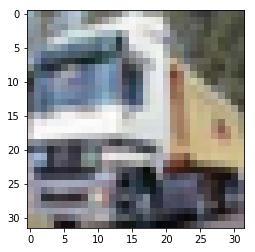

In [10]:
plt.imshow(x_train[1])

## One hot encode

In [11]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test,10)

In [12]:
y_train[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [13]:
# def one_hot_encode(x,num_class):
#     """
#         argument
#             - x: a list of labels
#         return
#             - one hot encoding matrix (number of labels, number of class)
#     """
#     encoded = np.zeros((len(x), num_class))
    
#     for idx, val in enumerate(x):
#         encoded[idx][val] = 1
    
#     return encoded

In [14]:
def one_hot_encode(x,num_class):
    encoded = np.zeros((len(x),num_class))
    for idx,val in enumerate(x):
        encoded[idx][val] = 1
    return encoded

In [15]:
def normalizeData(x):
    xmin = np.min(x)
    xmax = np.max(x)
    xNorm = (x-xmin)/(xmax-xmin)
    return xNorm

In [16]:
# Normalize x_train and x_test data
x_train = normalizeData(x_train)
x_test = normalizeData(x_test)

In [17]:
class HelpClass():
    def __init__(self):
        self.i = 0
        # Intialize some empty variables for later on
        #self.x_img = x_train
        #self.y_img = y_train
        
    def next_batch(self,batch_size):
        x = x_train[self.i:self.i+batch_size,:,:,:]
        y = y_train[self.i:self.i+batch_size,:]
        self.i=(self.i + batch_size) % len(x_train)
        return x,y
    
    def random_batch(self,batch_size):
        imglen = len(x_train)
        idx = np.random.choice(imglen,size=batch_size,replace=False)
        x_batch = x_train[idx,:,:,:]
        y_batch = y_train[idx,:]
        return x_batch,y_batch

## Placeholder

In [18]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

In [19]:
x = tf.placeholder(dtype=tf.float32,shape=[None,32,32,3])

In [20]:
y_true = tf.placeholder(dtype=tf.float32,shape=[None,10])

In [21]:
drop_p = tf.placeholder(dtype=tf.float32)

In [22]:
# Init Weights
def init_weights(shape):
    # init_random_dist = tf.truncated_normal(shape=shape,stddev=0.1)
    # init_random_dist = tf.get_variable('wc11',shape=shape,dtype=tf.float32,
    #                                   initializer=tf.contrib.layers.xavier_initializer())
    initializer = tf.contrib.layers.xavier_initializer()
    w1 = tf.Variable(initializer(shape))
    #return tf.Variable(init_random_dist)    
    return w1

In [23]:
# Init Bias
def init_bias(shape):
    initializer = tf.contrib.layers.xavier_initializer()
    b1 = tf.Variable(initializer(shape))
    #init_bias_val = tf.constant(value=0.1,shape=shape)
    #return tf.Variable(init_bias_val)
    return b1

In [24]:
# Max Pooling
def max_pooling_2by2(x,k=2):
    # x = [batch,h,w,c]
    return tf.nn.max_pool(value=x,ksize=[1,k,k,1],strides=[1,k,k,1],padding='SAME')

In [25]:
def convlayer(x,shape,stride=1):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    x = tf.nn.conv2d(input=x,filter=W,strides=[1,stride,stride,1],padding='SAME')
    #x = tf.nn.bias_add(x,b)
    return tf.nn.relu(x+b)

In [26]:
def full_layer(input_layer,size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size,size])
    b = init_bias([size])
    return tf.matmul(input_layer,W)+b

In [27]:
def conv_net(x,drop_prob):
    # Conv Layer 1
    conv1 = convlayer(x=x,shape=[3,3,3,64],stride=1)
    # Max Pooling 1
    conv1 = max_pooling_2by2(x=conv1,k=2)
    # Batch Normalization 1
    conv1 = tf.layers.batch_normalization(conv1)
    
    # Conv Layer 2
    conv2 = convlayer(x=conv1,shape=[3,3,64,128],stride=1)
    # Max Pooling 2
    conv2 = max_pooling_2by2(x=conv2,k=2)
    # Batch NOrmalization 2
    conv2 = tf.layers.batch_normalization(conv2)
    
    # Conv Layer 3
    conv3 = convlayer(x=conv2,shape=[5,5,128,256],stride=1)
    # Max Pooling 1
    conv3 = max_pooling_2by2(x=conv3,k=2)
    # Batch Normalization 1
    conv3 = tf.layers.batch_normalization(conv3)
    
    # Conv Layer 4
    conv4 = convlayer(x=conv3,shape=[5,5,256,512],stride=1)
    # Max Pooling 2
    conv4 = max_pooling_2by2(x=conv4,k=2)
    # Batch NOrmalization 2
    conv4 = tf.layers.batch_normalization(conv4)
    
    # Flatten Conv 4 Layer - reshape
    # 32/2/2/2/2 = 2
    conv4_flat = tf.reshape(conv4,shape=[-1,2*2*512])
        
    # Fully Connected Layer 1 - Dense Layer
    fullnet1 = tf.nn.relu(full_layer(input_layer=conv4_flat,size=128))
    # Dropout layer 1
    fullnet1 = tf.nn.dropout(x=fullnet1,keep_prob=drop_p)
    # Full Batch Normalization 1
    fullnet1 = tf.layers.batch_normalization(fullnet1)
    
    # Fully Connected Layer 2 - Dense Layer
    fullnet2 = tf.nn.relu(full_layer(input_layer=fullnet1,size=256))
    # Dropout layer 1
    fullnet2 = tf.nn.dropout(x=fullnet2,keep_prob=drop_p)
    # Full Batch Normalization 2
    fullnet2 = tf.layers.batch_normalization(fullnet2)
    
    # Fully Connected Layer 2 - Dense Layer
    fullnet3 = tf.nn.relu(full_layer(input_layer=fullnet2,size=512))
    # Dropout layer 1
    fullnet3 = tf.nn.dropout(x=fullnet3,keep_prob=drop_p)
    # Full Batch Normalization 2
    fullnet3 = tf.layers.batch_normalization(fullnet3)
    
    # Fully Connected Layer 2 - Dense Layer
    fullnet4 = tf.nn.relu(full_layer(input_layer=fullnet3,size=1024))
    # Dropout layer 1
    fullnet4 = tf.nn.dropout(x=fullnet4,keep_prob=drop_p)
    # Full Batch Normalization 2
    fullnet4 = tf.layers.batch_normalization(fullnet4)
    
    out = full_layer(fullnet4,num_class)
    # out = full_layer(fullnet3,num_class)
    # out = tf.contrib.layers.fully_connected(inputs=fullnet4, num_outputs=10, activation_fn=None)
    return out

In [28]:
logits = conv_net(x,drop_p)

In [29]:
# Cost Loss Function
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=logits))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [30]:
# Optimizer function
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [31]:
train_op = optimizer.minimize(loss=loss_op)

In [32]:
init = tf.global_variables_initializer()

In [33]:
# Accuracy
correct_pred = tf.equal(tf.argmax(logits,1),tf.argmax(y_true,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred,dtype=tf.float32))

In [34]:
hc = HelpClass()

In [35]:
# Session
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_steps):
        # x_batch,y_batch = hc.random_batch(batch_size)
        x_batch,y_batch = hc.next_batch(batch_size)
        sess.run(train_op,feed_dict={x:x_batch,y_true:y_batch,drop_p:dropout})
        if i%display_step==0:
            print('On Steps: {}'.format(i))
            print('Accuracy: ')
            print(sess.run(accuracy,feed_dict={x:x_test,y_true:y_test,drop_p:1.0}))
            print('\n')

On Steps: 0
Accuracy: 
0.1


On Steps: 100
Accuracy: 
0.1274


On Steps: 200
Accuracy: 
0.1857


On Steps: 300
Accuracy: 
0.2583


On Steps: 400
Accuracy: 
0.2977


On Steps: 500
Accuracy: 
0.3309


On Steps: 600
Accuracy: 
0.3415


On Steps: 700
Accuracy: 
0.4251


On Steps: 800
Accuracy: 
0.4184


On Steps: 900
Accuracy: 
0.4581


On Steps: 1000
Accuracy: 
0.5099


On Steps: 1100
Accuracy: 
0.5393


On Steps: 1200
Accuracy: 
0.4828


On Steps: 1300
Accuracy: 
0.5585


On Steps: 1400
Accuracy: 
0.5652


On Steps: 1500
Accuracy: 
0.5675


On Steps: 1600
Accuracy: 
0.5937


On Steps: 1700
Accuracy: 
0.5762


On Steps: 1800
Accuracy: 
0.6041


On Steps: 1900
Accuracy: 
0.62


On Steps: 2000
Accuracy: 
0.6132


On Steps: 2100
Accuracy: 
0.6413


On Steps: 2200
Accuracy: 
0.6319


On Steps: 2300
Accuracy: 
0.6225


On Steps: 2400
Accuracy: 
0.6469


On Steps: 2500
Accuracy: 
0.6624


On Steps: 2600
Accuracy: 
0.6556


On Steps: 2700
Accuracy: 
0.6653


On Steps: 2800
Accuracy: 
0.6512


On